Downloading a dataset that contains addresses and plot them over legislative district.

https://data.delaware.gov/Energy-and-Environment/Energy-Efficiency-Investment-Fund-EEIF-Grants-FY-2/vukm-g6g5

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

pd.options.display.max_columns = 100
EEIF_df = pd.read_csv("/Users/kamran/Downloads/DSHA/Energy_Efficiency_Investment_Fund__EEIF__Grants__FY_2017_to_Present.csv")

# Load the Delaware dry land shapefile as a GeoDataFrame
USmap = gpd.read_file("/Users/kamran/Downloads/Shapefiles/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")

# Create a GeoDataFrame from the latitude and longitude columns
geometry = gpd.points_from_xy(EEIF_df['Longitude'], EEIF_df['Latitude'])
EEIF_gdf = gpd.GeoDataFrame(EEIF_df, geometry=geometry)
EEIF_gdf['Date'] = pd.to_datetime(EEIF_gdf['App Completed/to Fiscal Date'])
EEIF_gdf['year'] = EEIF_gdf['Date'].dt.strftime('%Y')
EEIF_gdf['% of cost'] = EEIF_gdf['Award, % of Total Project Cost']*100


In [2]:
EEIF_gdf.dropna(subset=['% of cost','year'], inplace=True)
EEIF_gdf = EEIF_gdf[['Name of Grantee','Final Award Amount','% of cost',
                     'Proposed Electricity Savings (kWh/yr)',
                     'Proposed Natural Gas Savings (kBtus/yr)','Greenhouse Gas Emission Reduction (MtCO2e)',
                     'year','geometry']]
EEIF_gdf.reset_index(drop=True)
EEIF_gdf.rename(columns={'Name of Grantee':'Name','Final Award Amount':'Award ($)',
                         'Proposed Electricity Savings (kWh/yr)':'Electricity Savings (kWh/yr)',
                         'Proposed Natural Gas Savings (kBtus/yr)':'Natural Gas Savings (kBtus/yr)'},inplace=True)

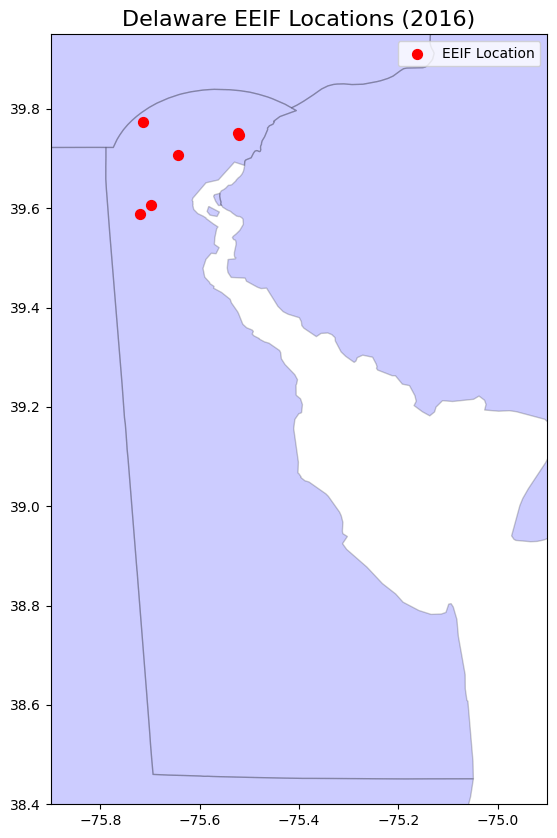

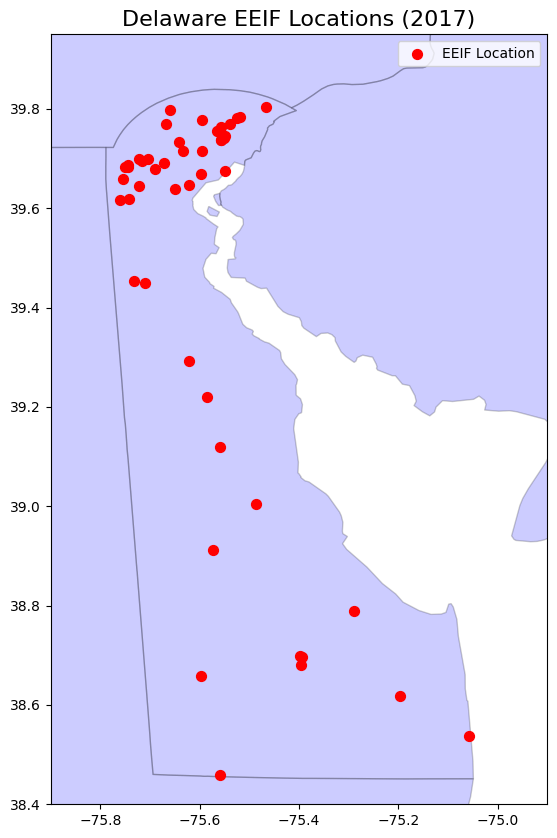

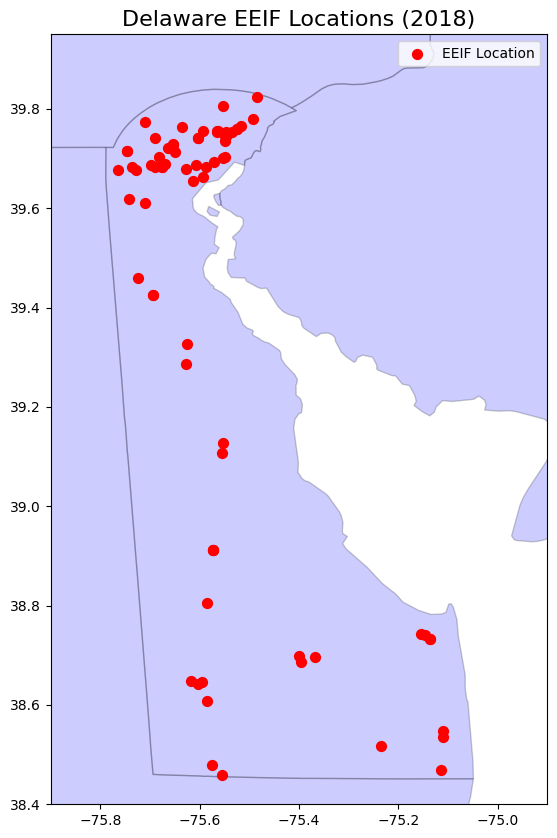

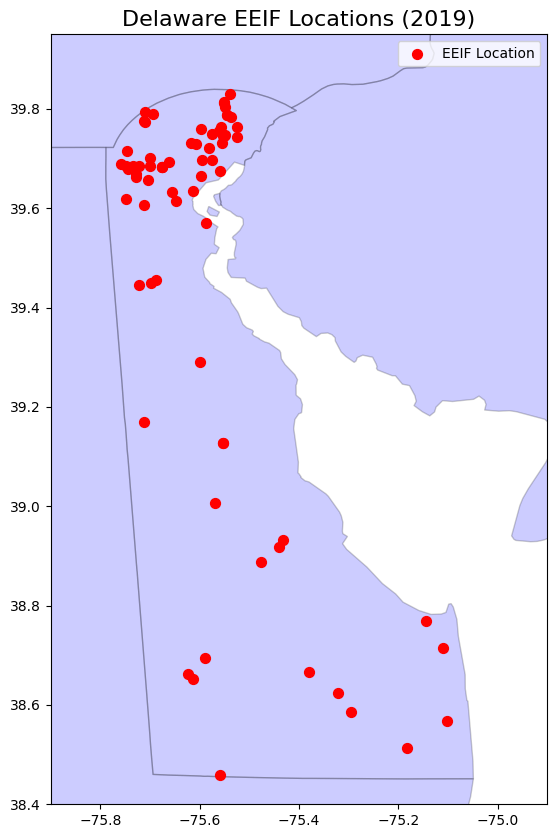

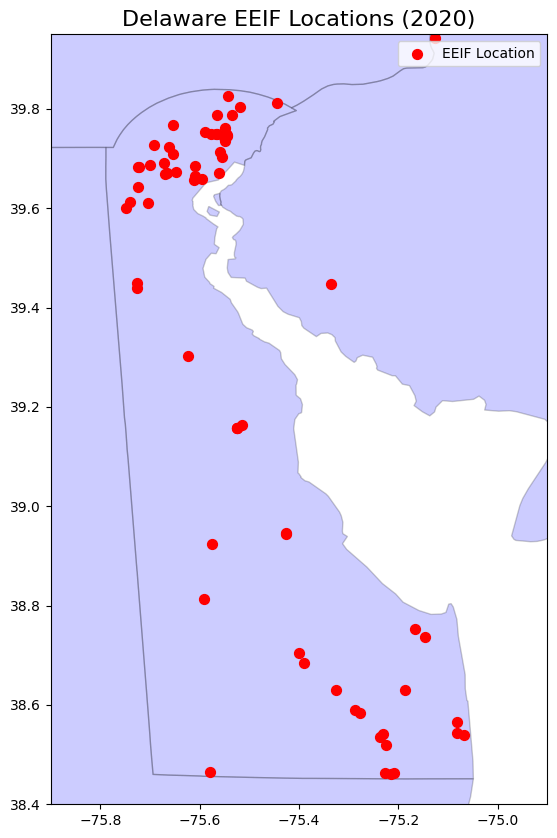

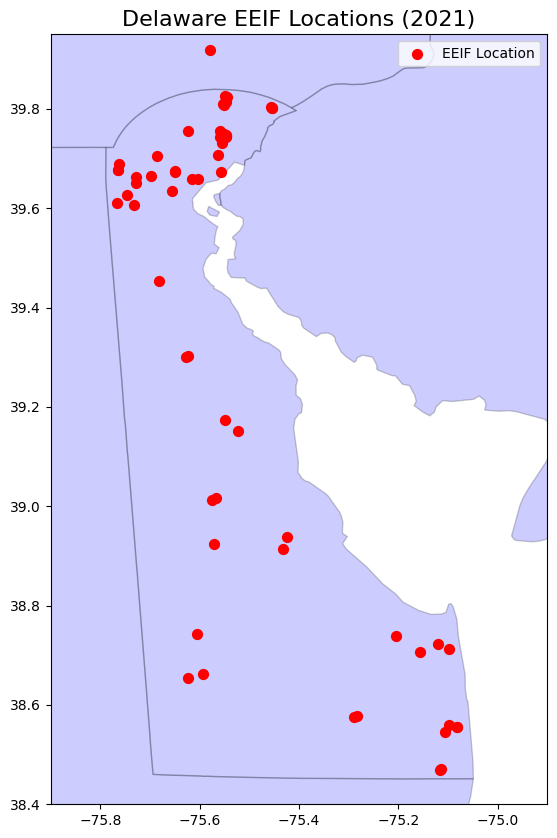

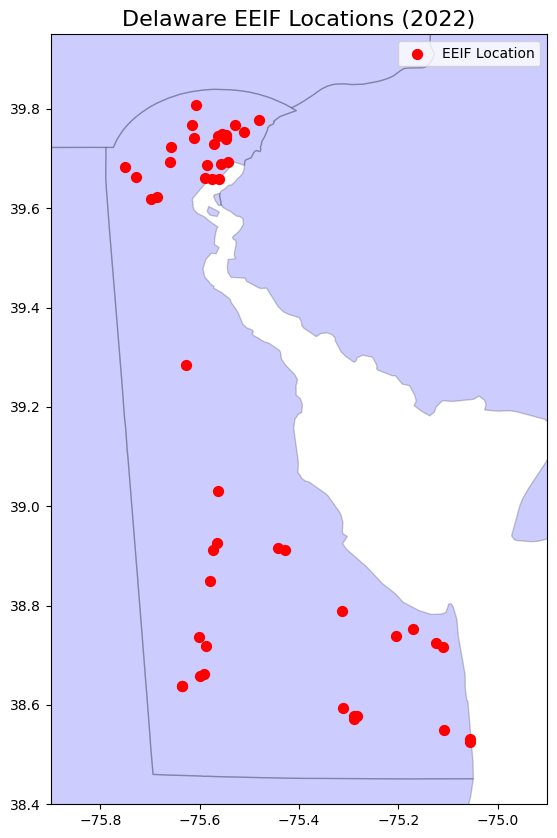

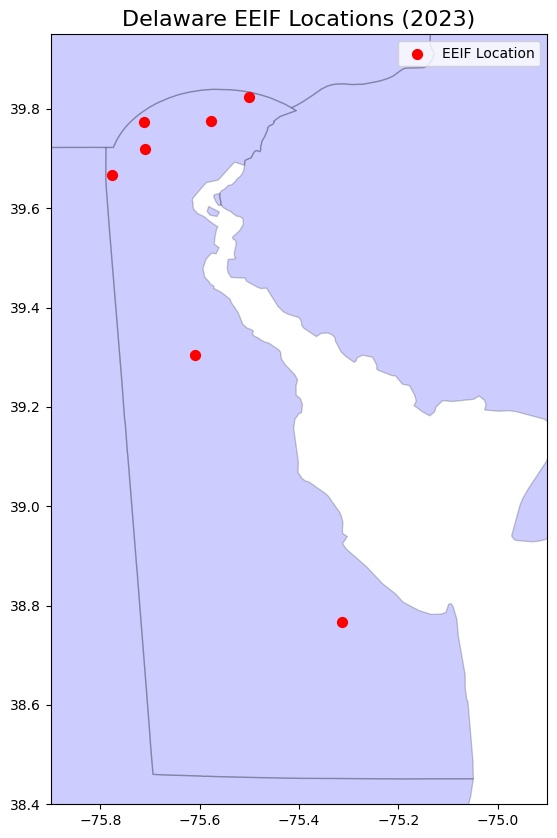

In [3]:
# Creating new dataframes for each year and plotting them.
year_list = EEIF_gdf.sort_values(by='year')['year'].unique()
EEIF_dic = {f'EEIF_{year}': EEIF_gdf[EEIF_gdf['year']==year].reset_index(drop=True).drop('year',axis=1).round(decimals=1) for year in year_list}

for key in EEIF_dic.keys():
    
    # Save the merged GeoDataFrame as a GeoJSON file
    output_file = f"/Users/kamran/Downloads/DSHA/DSHA_EEIF_all_years/{key}.json"
    EEIF_dic[key].reset_index().to_file(output_file, driver='GeoJSON')
    
    # Plot the map of US and focuse on Delaware
    fig, ax = plt.subplots(figsize=(10, 10))
    USmap.plot(ax=ax, color='blue', edgecolor='black', linewidth=1, alpha=0.2)

    # Overlay the points from the gdf_EEIF GeoDataFrame
    EEIF_dic[key].plot(ax=ax, color='red', markersize=50, label='EEIF Location')
    ax.set_xlim([-75.9, -74.9])
    ax.set_ylim([38.4, 39.95])

    # Set plot title and legend
    ax.set_title(f"Delaware EEIF Locations ({key[5:]})", fontsize=16)
    ax.legend()

    plt.savefig(f"/Users/kamran/Downloads/DSHA/DSHA_EEIF_all_years/EEIF_{key[5:]}.png", dpi=300)